In [14]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [15]:
train_df = pd.read_csv("data/twitter_data_train_multiclass.csv")
test_df = pd.read_csv("data/twitter_data_test_multiclass.csv")

print(train_df.shape)
print(test_df.shape)

(9446, 238)
(1667, 238)


In [16]:
to_drop = [
    'Unnamed: 0',
    'account_type', 
    'account_type_multi',
    'id', 
    'name', 
    'screen_name',
    'profile_image_url',
    'protected',
    'verified',
    'description',
    'description_processed',
    'tweets_list',
    'tweets_list_processed',
    'url',
    'profile_use_background_image', 
    'profile_background_tile'
    ]

scaler = MinMaxScaler() 
train_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']] = scaler.fit_transform(train_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']])
test_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']] = scaler.transform(test_df[['statuses_count', 'favourites_count', 'followers_count', 'friends_count', 'number_of_mentions', 'listed_count', 'number_of_tags']])

X_train, y_train = train_df.drop(to_drop, axis=1), train_df['account_type_multi']
X_test, y_test = test_df.drop(to_drop, axis=1), test_df['account_type_multi']



**Random Forest model training and testing**

In [17]:
# Random forest model 
# training
regressor = RandomForestClassifier(n_estimators=100, max_depth=5 )
regressor.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

**Evaluate Model Performance**

In [18]:
# train
y_pred_train = regressor.predict(X_train)
print(classification_report(y_train, y_pred_train, digits=5))
# roc_auc_score(y_train, y_pred_train, multi_class='ovr')

              precision    recall  f1-score   support

           0    0.93948   0.98931   0.96375      2338
           1    0.97165   0.98780   0.97966      2706
           2    0.99774   0.88487   0.93792      1494
           3    0.98659   0.98659   0.98659      2908

    accuracy                        0.97152      9446
   macro avg    0.97386   0.96214   0.96698      9446
weighted avg    0.97241   0.97152   0.97125      9446



In [19]:
# test
y_pred_test = regressor.predict(X_test)
print(classification_report(y_test, y_pred_test, digits=5))
# roc_auc_score(y_test, y_pred_test)

              precision    recall  f1-score   support

           0    0.91874   0.98547   0.95093       413
           1    0.96406   0.99130   0.97749       460
           2    1.00000   0.89130   0.94253       276
           3    0.99604   0.97104   0.98338       518

    accuracy                        0.96701      1667
   macro avg    0.96971   0.95978   0.96358      1667
weighted avg    0.96872   0.96701   0.96695      1667



**Hyperparameter Tuning**

We will use RandomizedSearchCV to narrow down the range for grid search hyperparameter tuning.


In [20]:
regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [21]:
# Number of trees in random forest
n_estimators = [50,100,150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [5,10,15,20,25,30,35,40,45,50]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(grid)

{'n_estimators': [50, 100, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]}


In [22]:
# Random forest model 
# training
regressor = RandomForestClassifier()

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=2022)

rf_randomcv = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=grid,
    n_iter=100, 
    cv=cv_method,
    verbose=2,
    random_state=2022,
    n_jobs=-1, # use all processors
    scoring='f1_weighted'
)

rf_randomcv.fit(X_train, y_train)


Fitting 15 folds for each of 100 candidates, totalling 1500 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=2022),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150]},
                   random_state=2022, scoring='f1_weighted', verbose=2)

In [23]:
rf_randomcv.best_params_

{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [24]:
rf_randomcv.best_score_

0.9900006556251232

**Use tuned classifier**

In [25]:
import time

from sklearn.metrics import f1_score

best_clf = RandomForestClassifier(**rf_randomcv.best_params_)

start_time = time.time()

best_clf.fit(X_train, y_train)
y_pred_test = best_clf.predict(X_test)

time_taken = time.time() - start_time
print("Total time taken for the program execution", time_taken) # seconds
print(classification_report(y_test, y_pred_test, digits=5))
# roc_auc_score(y_test, y_pred_test)
f1_score(y_test, y_pred_test, average='weighted')

Total time taken for the program execution 3.4357147216796875
              precision    recall  f1-score   support

           0    0.95561   0.99031   0.97265       413
           1    0.99567   1.00000   0.99783       460
           2    0.99265   0.97826   0.98540       276
           3    1.00000   0.97490   0.98729       518

    accuracy                        0.98620      1667
   macro avg    0.98598   0.98587   0.98579      1667
weighted avg    0.98659   0.98620   0.98626      1667



0.9862600389216334

Visualising some of the trees in the random forest

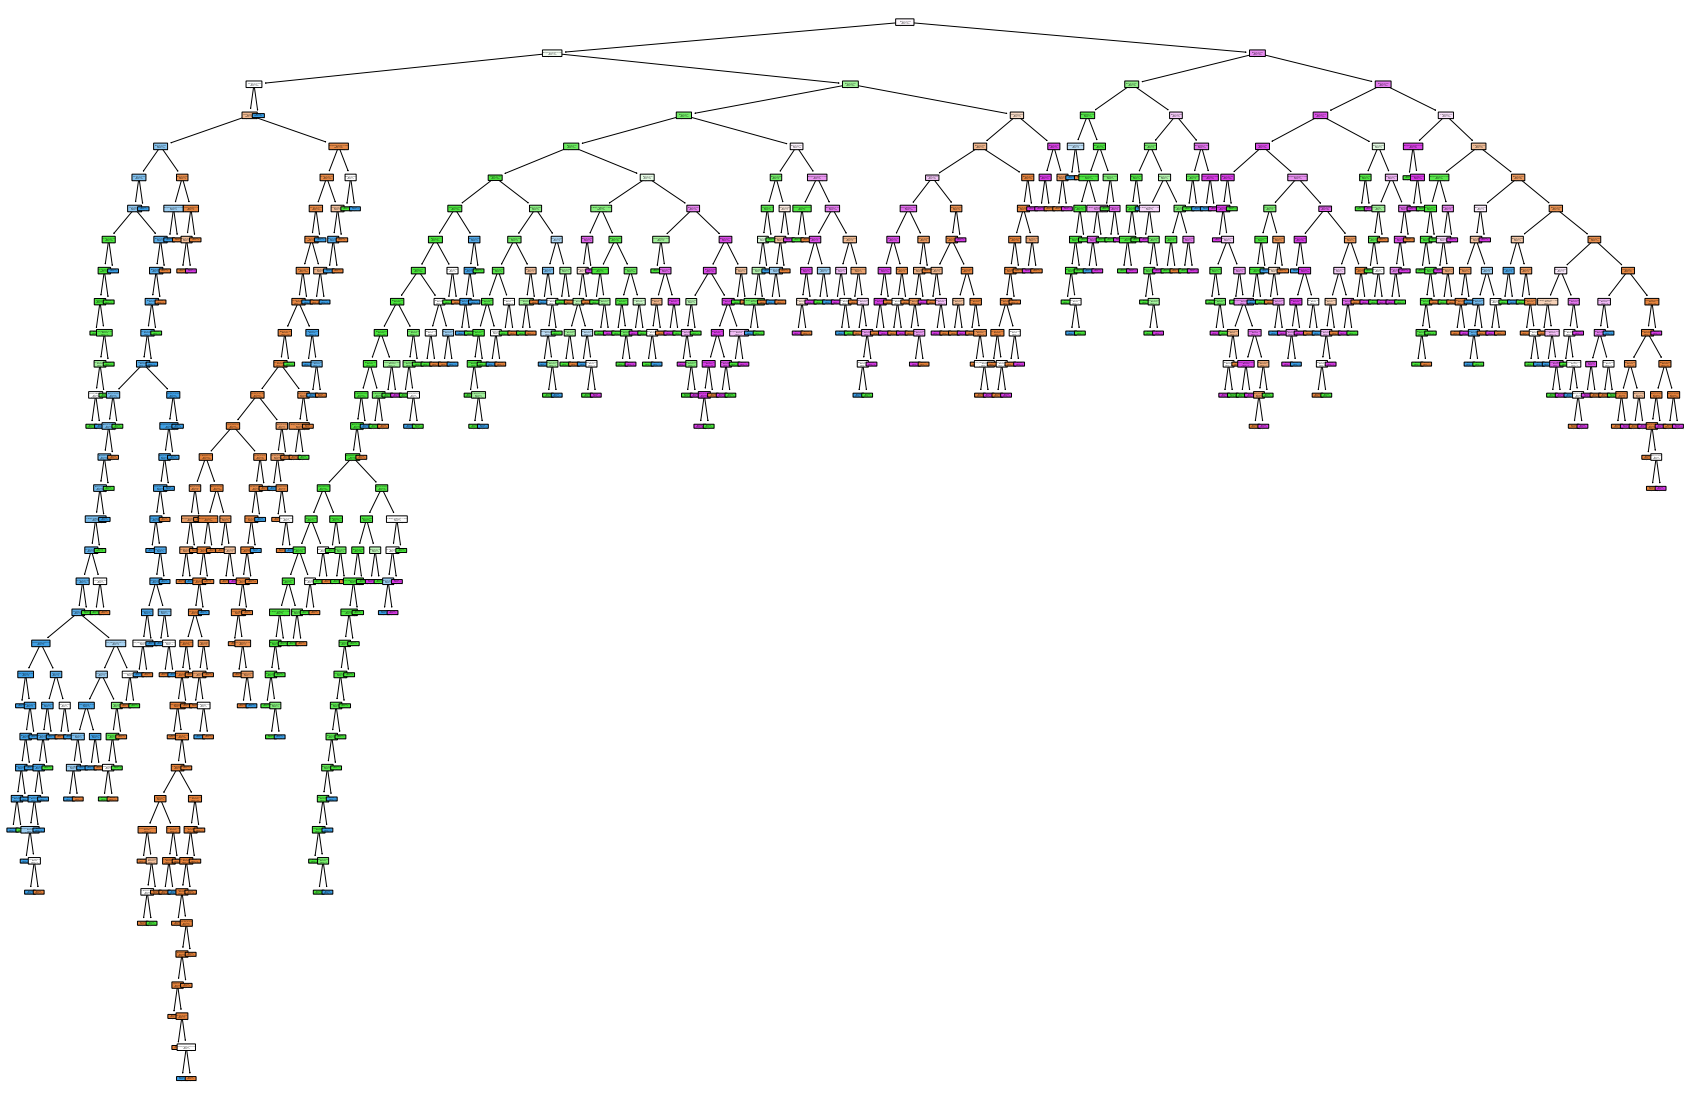

In [29]:

fig = plt.figure(figsize=(30, 20))
plot_tree(best_clf.estimators_[0], 
          feature_names=X_train.columns,
        #   class_names=["0","1"], 
          filled=True, rounded=True)

plt.show()